# Dermatologist-AI Project: Single Network Approach
Workbook for a single network approach that classifies images into melanomas, nevus, or SBK

### Set up and process data

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from keras.applications.vgg19 import preprocess_input
from tqdm import tqdm
from PIL import ImageFile                            
import os
import pickle
ImageFile.LOAD_TRUNCATED_IMAGES = True      


# define function to load train, test, and validation datasets
def load_dataset(path, shuffle):
    data = load_files(path, shuffle=shuffle)
    file_paths = np.array(data['filenames'])
    one_hot_labels = np_utils.to_categorical(np.array(data['target']),3)
    return file_paths, one_hot_labels

# define functions to convert images into 4D tensors for convnets
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors) 

# define function to decide whether to load tensors from a saved pickle or raw images
def load_tensors_and_labels(pickle_file, raw_file_path, shuffle, force=False):
    pickle_file = os.path.join('.', pickle_file)
 
    if force or not os.path.exists(pickle_file):
        files, labels = load_dataset(raw_file_path, shuffle)
        tensors = paths_to_tensor(files).astype('float32')/255
        with open(pickle_file, 'wb') as handle:
            pickle.dump([tensors, labels], handle, protocol=pickle.HIGHEST_PROTOCOL)
        return tensors, labels

    else:        
        with open(pickle_file, 'rb') as handle:
            tensors, labels = pickle.load(handle)        
        return tensors, labels
    

Using TensorFlow backend.


In [2]:
# Load data

train_tensors, train_labels = load_tensors_and_labels('train_data.pickle','../data/train', True)
valid_tensors, valid_labels = load_tensors_and_labels('valid_data.pickle','../data/valid', True)
test_tensors, test_labels = load_tensors_and_labels('test_data.pickle','../data/test', False)

# load list of skin condition names
skin_names = [item[14:-1] for item in sorted(glob("../data/train/*/"))]


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [03:19<00:00, 11.11it/s]


Network based on four three layers of VGG19 followed by trainable convnet and dense layers

In [65]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

#First 4 blocks of VGG19
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv1', 
                        input_shape=(224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', trainable=False, name='block1_conv2'))
model.add(MaxPooling2D(pool_size=2, name='block1_pool'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv1'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', trainable=False, name='block2_conv2'))
model.add(MaxPooling2D(pool_size=2, name='block2_pool'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv1'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv2'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv3'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', trainable=False, name='block3_conv4'))
model.add(MaxPooling2D(pool_size=2, name='block3_pool'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv1'))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv2'))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv3'))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=False, name='block4_conv4'))
model.add(MaxPooling2D(pool_size=2, name='block4_pool'))

#First 1 trainable convnet block
model.add(Dropout(0.5))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv1'))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', trainable=True, name='block5_conv2'))
model.add(MaxPooling2D(pool_size=2, name='block5_pool'))
model.add(Dropout(0.5))

#Trainable dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

Import and assign VGG19 weights

In [66]:
from keras import optimizers
opt = optimizers.rmsprop(lr=0.00005, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
from keras import applications
import h5py

weights_path = 'vgg19_weights.h5'
f = h5py.File(weights_path, 'r')

VGGnet_layers = ['block1_conv1',
                 'block1_conv2',
                 'block2_conv1',
                 'block2_conv2',
                 'block3_conv1',
                 'block3_conv2',
                 'block3_conv3',
                 'block3_conv4',
                 'block4_conv1',
                 'block4_conv2',
                 'block4_conv3',
                 'block4_conv4']
layer_names = [layer.name for layer in model.layers]

for i in VGGnet_layers:
    weight_names = f[i].attrs["weight_names"]    
    weights = [f[i][j] for j in weight_names]
    index = layer_names.index(i)
    model.layers[index].set_weights(weights)


In [68]:
from keras.callbacks import ModelCheckpoint  

epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights1.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_labels,
            validation_data=(valid_tensors, valid_labels),
            epochs=epochs,
            batch_size=20,
            callbacks=[checkpointer],
            verbose=1)

Train on 2000 samples, validate on 150 samples
Epoch 1/20
2000/2000 [==============================] - 84s - loss: 1.2061 - acc: 0.6020 - val_loss: 1.0866 - val_acc: 0.5133
Epoch 2/20
2000/2000 [==============================] - 81s - loss: 0.8281 - acc: 0.6725 - val_loss: 0.8721 - val_acc: 0.6267
Epoch 3/20


2000/2000 [==============================] - 81s - loss: 0.7447 - acc: 0.6840 - val_loss: 0.8502 - val_acc: 0.6267
Epoch 4/20
2000/2000 [==============================] - 81s - loss: 0.6845 - acc: 0.6975 - val_loss: 0.8392 - val_acc: 0.5800
Epoch 5/20


2000/2000 [==============================] - 80s - loss: 0.6231 - acc: 0.7280 - val_loss: 0.7600 - val_acc: 0.6600
Epoch 6/20
2000/2000 [==============================] - 82s - loss: 0.5853 - acc: 0.7475 - val_loss: 0.7635 - val_acc: 0.6800
Epoch 7/20


2000/2000 [==============================] - 81s - loss: 0.5453 - acc: 0.7645 - val_loss: 0.7191 - val_acc: 0.6800
Epoch 8/20
2000/2000 [==============================] - 81s - loss: 0.5144 - acc: 0.7795 - val_loss: 0.7645 - val_acc: 0.7133
Epoch 9/20


2000/2000 [==============================] - 81s - loss: 0.4705 - acc: 0.8020 - val_loss: 0.8404 - val_acc: 0.6400
Epoch 10/20
2000/2000 [==============================] - 86s - loss: 0.4496 - acc: 0.8175 - val_loss: 0.7487 - val_acc: 0.6800
Epoch 11/20


2000/2000 [==============================] - 80s - loss: 0.3895 - acc: 0.8455 - val_loss: 0.7794 - val_acc: 0.6800
Epoch 12/20
2000/2000 [==============================] - 81s - loss: 0.3629 - acc: 0.8550 - val_loss: 0.8085 - val_acc: 0.6867
Epoch 13/20


2000/2000 [==============================] - 81s - loss: 0.3414 - acc: 0.8695 - val_loss: 1.0951 - val_acc: 0.7133
Epoch 14/20
1220/2000 [=================>............] - ETA: 74s - loss: 0.5031 - acc: 0.80 - ETA: 74s - loss: 0.3370 - acc: 0.87 - ETA: 73s - loss: 0.2916 - acc: 0.88 - ETA: 72s - loss: 0.2924 - acc: 0.86 - ETA: 72s - loss: 0.3160 - acc: 0.85 - ETA: 71s - loss: 0.3354 - acc: 0.83 - ETA: 70s - loss: 0.3519 - acc: 0.84 - ETA: 69s - loss: 0.3339 - acc: 0.86 - ETA: 69s - loss: 0.3336 - acc: 0.86 - ETA: 68s - loss: 0.3416 - acc: 0.86 - ETA: 67s - loss: 0.3456 - acc: 0.85 - ETA: 66s - loss: 0.3428 - acc: 0.86 - ETA: 70s - loss: 0.3265 - acc: 0.86 - ETA: 68s - loss: 0.3224 - acc: 0.86 - ETA: 67s - loss: 0.3100 - acc: 0.87 - ETA: 66s - loss: 0.3131 - acc: 0.86 - ETA: 65s - loss: 0.3073 - acc: 0.86 - ETA: 65s - loss: 0.3107 - acc: 0.86 - ETA: 64s - loss: 0.3108 - acc: 0.86 - ETA: 63s - loss: 0.3030 - acc: 0.87 - ETA: 62s - loss: 0.2975 - acc: 0.87 - ETA: 61s - loss: 0.2923 - acc:

KeyboardInterrupt: 

## Create output .csv for testing

In [69]:
# Load the model weights with the best validation loss.

model.load_weights('saved_models/weights1.hdf5')

In [72]:
import pandas as pd

y_pred = pd.DataFrame(columns=["task_1", "task_2"])

for ii in tqdm(range(len(test_labels))):
    #path = test_files[ii]
    prediction = np.argmax(model.predict(np.expand_dims(test_tensors[ii], axis=0)))
    if prediction == 0:
        y_pred.loc[ii] = [1, 0]
    if prediction == 2:
        y_pred.loc[ii] = [0, 1]
    else:
        y_pred.loc[ii] = [0, 0]

y_pred.to_csv("predictions.csv")

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 44.28it/s]


## Internal testing vs. ground truths

In [73]:
import itertools
import keras
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

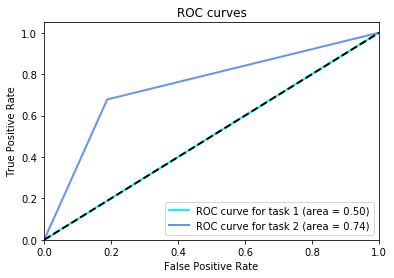

Category 1 Score: 0.500
Category 2 Score: 0.745
Category 3 Score: 0.622


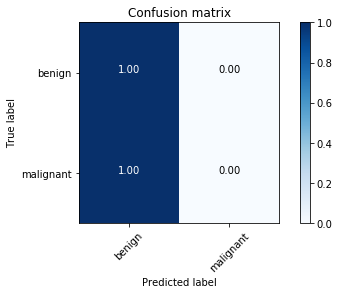

In [74]:
preds_path = sys.argv[1]
thresh = 0.5

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv("predictions.csv")
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)
